In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## What does LDA do?
LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

- The quality of text processing.
- The variety of topics the text talks about.
- The choice of topic modeling algorithm.
- The number of topics fed to the algorithm.
- The algorithms tuning parameters.

## Process

### Import prepared data

In [7]:
!pwd && ls ../Data/All*

/media/abiricz/Storage2/ELTE/Fizika9félév/Data Science Computer Lab/Project2/dslab2018_project2
../Data/All_filtered.txt  ../Data/All_filtered.txt.gz


In [8]:
%%time
data = pd.read_csv( '../Data/All_filtered.txt.gz', compression='gzip', 
                    delimiter='\t', names=['Tweets', 'Targets'] )

CPU times: user 364 ms, sys: 25.7 ms, total: 389 ms
Wall time: 392 ms


In [9]:
data.head()

,Tweets,Targets
0,aaaah final saw thor even better than expect w...,cinema
1,aaaahhh food benthanh street food market,market
2,aaa am so happi succeed in buy ticket to the c...,cinema
3,aaaand no question on climat or environ not su...,climate
4,aaaand on the job market too,market


In [10]:
tweets = data['Tweets'].values.tolist()
targets = data['Targets'].values.tolist()
tweets[0], targets[0]

('aaaah final saw thor even better than expect we laugh indec amount for finnish cinema ka raw you gem',
 'cinema')

In [11]:
%%time
data_words = []
for i in range( len(tweets) ):
    data_words.append( tweets[i].split() )

CPU times: user 365 ms, sys: 52.2 ms, total: 417 ms
Wall time: 415 ms


In [12]:
np.shape(data_words), np.shape(targets)

((219941,), (219941,))

### Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [13]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/abiricz/.local/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['aaaah', 'final', 'saw', 'thor', 'even', 'better', 'than', 'expect', 'we', 'laugh', 'indec', 'amount', 'for', 'finnish', 'cinema', 'ka', 'raw', 'you', 'gem']
CPU times: user 33.5 s, sys: 111 ms, total: 33.7 s
Wall time: 33.7 s


### Make Bigrams

In [14]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [15]:
%%time
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

CPU times: user 6.92 s, sys: 83.8 ms, total: 7 s
Wall time: 7 s


### Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

In [16]:
np.shape( data_words_bigrams )

(219941,)

In [17]:
%time 

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

In [18]:
%%time
id2word = corpora.Dictionary(data_words_bigrams)

texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]
CPU times: user 5.92 s, sys: 95.8 ms, total: 6.02 s
Wall time: 6.02 s


In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aaaah', 1),
  ('amount', 1),
  ('better', 1),
  ('cinema', 1),
  ('even', 1),
  ('expect', 1),
  ('final', 1),
  ('finnish', 1),
  ('for', 1),
  ('gem', 1),
  ('indec', 1),
  ('ka', 1),
  ('laugh', 1),
  ('raw', 1),
  ('saw', 1),
  ('than', 1),
  ('thor', 1),
  ('we', 1),
  ('you', 1)]]

### Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [20]:
%%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

KeyboardInterrupt: 

### View the topics in LDA model

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [37]:
# Print the Keyword in the 10 topics
pprint( lda_model.print_topics() )
doc_lda = lda_model[corpus]

[(0,
  '0.194*"to" + 0.130*"and" + 0.095*"concert" + 0.057*"on" + 0.054*"this" + '
  '0.052*"with" + 0.037*"was" + 0.029*"my" + 0.022*"year" + 0.018*"yeah"'),
 (1,
  '0.065*"night" + 0.038*"hope" + 0.038*"give" + 0.036*"must" + 0.034*"parti" '
  '+ 0.031*"alway" + 0.029*"its" + 0.029*"fan" + 0.020*"away" + 0.017*"fun"'),
 (2,
  '0.060*"best" + 0.049*"ever" + 0.039*"use" + 0.038*"physic" + 0.037*"thing" '
  '+ 0.033*"ll" + 0.033*"into" + 0.031*"being" + 0.023*"young" + '
  '0.021*"without"'),
 (3,
  '0.101*"see" + 0.089*"right" + 0.083*"time" + 0.056*"before" + 0.023*"open" '
  '+ 0.019*"someon" + 0.017*"place" + 0.016*"head" + 0.015*"christma" + '
  '0.015*"pay"'),
 (4,
  '0.143*"go" + 0.111*"climat" + 0.074*"chang" + 0.039*"could" + 0.031*"wish" '
  '+ 0.029*"let" + 0.028*"stop" + 0.028*"everi" + 0.022*"run" + '
  '0.019*"american"'),
 (5,
  '0.102*"me" + 0.054*"last" + 0.053*"never" + 0.041*"call" + 0.026*"amaz" + '
  '0.026*"during" + 0.022*"better" + 0.019*"sure" + 0.017*"end" + '


The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be?

### Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [38]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.170077735096758

Coherence Score:  0.26106491807939797


### Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/abiricz/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.380374 -0.286813       1        1  24.907717
0      0.233929  0.374696       2        1  13.946435
19     0.059713  0.023625       3        1   6.386699
13     0.128316  0.062891       4        1   6.133837
9      0.024128  0.005085       5        1   4.692767
17    -0.001301 -0.000620       6        1   4.687242
10    -0.035306 -0.009155       7        1   3.634151
7     -0.047987 -0.010453       8        1   3.269422
11    -0.006389 -0.004409       9        1   3.263285
12    -0.068366 -0.013055      10        1   3.126438
16    -0.033890 -0.009454      11        1   2.930114
4     -0.036453 -0.009629      12        1   2.927520
5     -0.057834 -0.012274      13        1   2.877520
14    -0.064143 -0.014237      14        1   2.773016
3     -0.076237 -0.016294      15        1   2.672491
15    -0.051744 -0.011374      16        1   2.666663
8     -0.079910 -0.016651      17        1   2.514332
6     -0.087963 -0.016878      18        1   2.327947
2     -0.078891 -0.016440      19        1   2.260944
1     -0.100045 -0.018558      20        1   2.001454, topic_info=     Category           Freq            Term          Total  loglift  logprob
term                                                                         
36    Default  127281.000000             the  127281.000000  30.0000  30.0000
18    Default  117624.000000             you  117624.000000  29.0000  29.0000
38    Default   82905.000000              to   82905.000000  28.0000  28.0000
22    Default   52513.000000          market   52513.000000  27.0000  27.0000
148   Default   55661.000000             and   55661.000000  26.0000  26.0000
8     Default   30979.000000             for   30979.000000  25.0000  25.0000
444   Default   26065.000000             nfl   26065.000000  24.0000  24.0000
116   Default   40416.000000         concert   40416.000000  23.0000  23.0000
223   Default   27498.000000            your   27498.000000  22.0000  22.0000
31    Default   51379.000000              in   51379.000000  21.0000  21.0000
57    Default   45952.000000           elect   45952.000000  20.0000  20.0000
175   Default   20924.000000              at   20924.000000  19.0000  19.0000
112   Default   14998.000000       terrorist   14998.000000  18.0000  18.0000
517   Default   13914.000000             can   13914.000000  17.0000  17.0000
95    Default   36045.000000              of   36045.000000  16.0000  16.0000
43    Default   35405.000000              is   35405.000000  15.0000  15.0000
46    Default   24353.000000              on   24353.000000  14.0000  14.0000
209   Default   23146.000000            this   23146.000000  13.0000  13.0000
293   Default   12789.000000              go   12789.000000  12.0000  12.0000
53    Default   22400.000000            with   22400.000000  11.0000  11.0000
136   Default   15392.000000            have   15392.000000  10.0000  10.0000
259   Default   11924.000000           about   11924.000000   9.0000   9.0000
29    Default   11202.000000             get   11202.000000   8.0000   8.0000
233   Default   13445.000000             yes   13445.000000   7.0000   7.0000
812   Default   12029.000000           would   12029.000000   6.0000   6.0000
41    Default    9981.000000          climat    9981.000000   5.0000   5.0000
32    Default   24789.000000              it   24789.000000   4.0000   4.0000
107   Default   24758.000000            that   24758.000000   3.0000   3.0000
173   Default   12388.000000             all   12388.000000   2.0000   2.0000
111   Default   23906.000000             are   23906.000000   1.0000   1.0000
...       ...            ...             ...            ...      ...      ...
152   Topic20    3961.369385           night    3962.290039   3.9111  -2.7392
216   Topic20    2321.506592            hope    2322.427246   3.9109  -3.2735
672   Topic20    2311.012207           

#### So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

#### Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

## Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [21]:
mallet_path = '../mallet-2.0.8/bin/mallet' # update this path

In [22]:
%%time
ldamallet = gensim.models.wrappers.LdaMallet( mallet_path, corpus=corpus, num_topics=20, id2word=id2word )

CPU times: user 6.57 s, sys: 76.1 ms, total: 6.65 s
Wall time: 2min 9s


In [23]:
%%time
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(12,
  [('terrorist', 0.13547487629561064),
   ('terror', 0.10094049618887632),
   ('attack', 0.025106562903539145),
   ('countri', 0.0193355960094621),
   ('white', 0.016901505022455347),
   ('kill', 0.01669580719256745),
   ('support', 0.015713028671991956),
   ('group', 0.013998880089592833),
   ('act', 0.013004673911801342),
   ('organ', 0.011450512530426137)]),
 (19,
  [('concert', 0.21292937653674807),
   ('night', 0.06288190471553425),
   ('live', 0.043284563137522214),
   ('tonight', 0.03242690556759257),
   ('amaz', 0.02383328870170655),
   ('music', 0.02163010930691141),
   ('life', 0.020023370742751418),
   ('perform', 0.015787423619056894),
   ('school', 0.013267765416169633),
   ('hall', 0.012001850183801155)]),
 (1,
  [('cinema', 0.12372304199772985),
   ('watch', 0.05238996090301425),
   ('movi', 0.01872871736662883),
   ('film', 0.01431454155631227),
   ('enjoy', 0.010556186152099887),
   ('cinemat', 0.010392231050573842),
   ('date', 0.009900365745995713),
   ('show',

## How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [45]:
%%time
model_list, coherence_values = compute_coherence_values( dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6 )

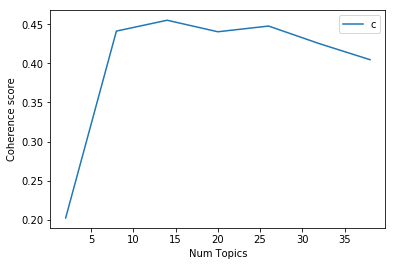

In [46]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2022
Num Topics = 8  has Coherence Value of 0.4414
Num Topics = 14  has Coherence Value of 0.4552
Num Topics = 20  has Coherence Value of 0.4405
Num Topics = 26  has Coherence Value of 0.4478
Num Topics = 32  has Coherence Value of 0.4253
Num Topics = 38  has Coherence Value of 0.4047


In [48]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.173*"market" + 0.038*"stock" + 0.016*"point" + 0.013*"singl" + '
  '0.011*"trade" + 0.011*"fall" + 0.010*"record" + 0.010*"public" + 0.010*"uk" '
  '+ 0.009*"drop"'),
 (1,
  '0.256*"elect" + 0.071*"vote" + 0.048*"trump" + 0.021*"win" + 0.020*"won" + '
  '0.019*"presid" + 0.018*"democrat" + 0.015*"lost" + 0.013*"russia" + '
  '0.012*"midterm"'),
 (2,
  '0.126*"climat" + 0.084*"chang" + 0.021*"real" + 0.019*"believ" + '
  '0.017*"polit" + 0.016*"world" + 0.013*"report" + 0.013*"caus" + '
  '0.011*"issu" + 0.009*"isn"'),
 (3,
  '0.186*"elect" + 0.042*"physic" + 0.026*"state" + 0.023*"parti" + '
  '0.021*"result" + 0.017*"general" + 0.014*"special" + 0.013*"candid" + '
  '0.012*"local" + 0.011*"offic"'),
 (4,
  '0.043*"realli" + 0.032*"concert" + 0.027*"fuck" + 0.026*"good" + '
  '0.025*"feel" + 0.024*"lol" + 0.020*"didn" + 0.019*"gonna" + 0.019*"someon" '
  '+ 0.018*"bad"'),
 (5,
  '0.168*"market" + 0.024*"busi" + 0.017*"plan" + 0.014*"check" + '
  '0.014*"event" + 0.012*"compan

### Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [49]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [50]:
%%time
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

ValueError: Wrong number of items passed 2, placement implies 219941

### Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [51]:
%%time
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

NameError: name 'df_topic_sents_keywords' is not defined

The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [52]:
%%time
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

NameError: name 'df_topic_sents_keywords' is not defined

## Conclusion
We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.

# MUST (!) LOOK AT THIS FOR BETTER VISUALIZATION: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

### T-SNE !